# University Database

This tutorial builds a complete university registration system to demonstrate:

- **Schema design** with realistic relationships
- **Data population** using Faker for synthetic data
- **Rich query patterns** from simple to complex

University databases are classic examples because everyone understands students, courses, enrollments, and grades. The domain naturally demonstrates:

- One-to-many relationships (department → courses)
- Many-to-many relationships (students ↔ courses via enrollments)
- Workflow dependencies (enrollment requires both student and section to exist)

In [1]:
import datajoint as dj
import numpy as np
from datetime import date

schema = dj.Schema('tutorial_university')

[2026-02-19 18:33:16] DataJoint 2.1.1 connected to postgres@postgres:5432


## Schema Design

Our university schema models:

| Table | Purpose |
|-------|--------|
| `Student` | Student records with contact info |
| `Department` | Academic departments |
| `StudentMajor` | Student-declared majors |
| `Course` | Course catalog |
| `Term` | Academic terms (Spring/Summer/Fall) |
| `Section` | Course offerings in specific terms |
| `Enroll` | Student enrollments in sections |
| `LetterGrade` | Grade scale (lookup) |
| `Grade` | Assigned grades |

In [2]:
@schema
class Student(dj.Manual):
    definition = """
    student_id : int64           # university-wide ID
    ---
    first_name : varchar(40)
    last_name : varchar(40)
    sex : enum('F', 'M', 'U')
    date_of_birth : date
    home_city : varchar(60)
    home_state : char(2)          # US state code
    """

In [3]:
@schema
class Department(dj.Manual):
    definition = """
    dept : varchar(6)   # e.g. BIOL, CS, MATH
    ---
    dept_name : varchar(200)
    """

In [4]:
@schema
class StudentMajor(dj.Manual):
    definition = """
    -> Student
    ---
    -> Department
    declare_date : date
    """

In [5]:
@schema
class Course(dj.Manual):
    definition = """
    -> Department
    course : int16               # course number, e.g. 1010
    ---
    course_name : varchar(200)
    credits : decimal(3,1)
    """

In [6]:
@schema
class Term(dj.Manual):
    definition = """
    term_year : int16
    term : enum('Spring', 'Summer', 'Fall')
    """

In [7]:
@schema
class Section(dj.Manual):
    definition = """
    -> Course
    -> Term
    section : char(1)
    ---
    auditorium : varchar(12)
    """

In [8]:
@schema
class Enroll(dj.Manual):
    definition = """
    -> Student
    -> Section
    """

In [9]:
@schema
class LetterGrade(dj.Lookup):
    definition = """
    grade : char(2)
    ---
    points : decimal(3,2)
    """
    contents = [
        ['A',  4.00], ['A-', 3.67],
        ['B+', 3.33], ['B',  3.00], ['B-', 2.67],
        ['C+', 2.33], ['C',  2.00], ['C-', 1.67],
        ['D+', 1.33], ['D',  1.00],
        ['F',  0.00]
    ]

In [10]:
@schema
class Grade(dj.Manual):
    definition = """
    -> Enroll
    ---
    -> LetterGrade
    """

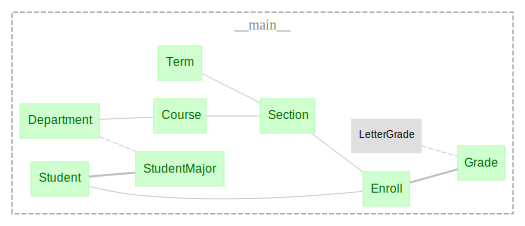

In [11]:
dj.Diagram(schema)

## Populate with Synthetic Data

We use [Faker](https://faker.readthedocs.io/) to generate realistic student data.

In [12]:
import faker
import random

fake = faker.Faker()
faker.Faker.seed(42)
random.seed(42)

In [13]:
def generate_students(n=500):
    """Generate n student records."""
    fake_name = {'F': fake.name_female, 'M': fake.name_male}
    for student_id in range(1000, 1000 + n):
        sex = random.choice(['F', 'M'])
        name = fake_name[sex]().split()[:2]
        yield {
            'student_id': student_id,
            'first_name': name[0],
            'last_name': name[-1],
            'sex': sex,
            'date_of_birth': fake.date_between(
                start_date='-35y', end_date='-17y'),
            'home_city': fake.city(),
            'home_state': fake.state_abbr()
        }

Student.insert(generate_students(500))
print(f"Inserted {len(Student())} students")

Inserted 500 students


In [14]:
# Departments
Department.insert([
    {'dept': 'CS', 'dept_name': 'Computer Science'},
    {'dept': 'BIOL', 'dept_name': 'Life Sciences'},
    {'dept': 'PHYS', 'dept_name': 'Physics'},
    {'dept': 'MATH', 'dept_name': 'Mathematics'},
])

# Assign majors to ~75% of students
students = Student.keys()
depts = Department.keys()
StudentMajor.insert(
    {
        **s, **random.choice(depts),
        'declare_date': fake.date_between(start_date='-4y')
    }
    for s in students if random.random() < 0.75
)
print(f"{len(StudentMajor())} students declared majors")

378 students declared majors


In [15]:
# Course catalog
Course.insert([
    ['BIOL', 1010, 'Biology in the 21st Century', 3],
    ['BIOL', 2020, 'Principles of Cell Biology', 3],
    ['BIOL', 2325, 'Human Anatomy', 4],
    ['BIOL', 2420, 'Human Physiology', 4],
    ['PHYS', 2210, 'Physics for Scientists I', 4],
    ['PHYS', 2220, 'Physics for Scientists II', 4],
    ['PHYS', 2060, 'Quantum Mechanics', 3],
    ['MATH', 1210, 'Calculus I', 4],
    ['MATH', 1220, 'Calculus II', 4],
    ['MATH', 2270, 'Linear Algebra', 4],
    ['MATH', 2280, 'Differential Equations', 4],
    ['CS', 1410, 'Intro to Object-Oriented Programming', 4],
    ['CS', 2420, 'Data Structures & Algorithms', 4],
    ['CS', 3500, 'Software Practice', 4],
    ['CS', 3810, 'Computer Organization', 4],
])
print(f"{len(Course())} courses in catalog")

15 courses in catalog


In [16]:
# Academic terms 2020-2024
Term.insert(
    {'term_year': year, 'term': term}
    for year in range(2020, 2025)
    for term in ['Spring', 'Summer', 'Fall']
)

# Create sections for each course-term with 1-3 sections
for course in Course.keys():
    for term in Term.keys():
        for sec in 'abc'[:random.randint(1, 3)]:
            if random.random() < 0.7:  # Not every course every term
                Section.insert1({
                    **course, **term,
                    'section': sec,
                    'auditorium': f"{random.choice('ABCDEF')}"
                                  f"{random.randint(100, 400)}"
                }, skip_duplicates=True)

print(f"{len(Section())} sections created")

339 sections created


In [17]:
# Enroll students in courses
terms = Term.keys()
for student in Student.keys():
    # Each student enrolls over 2-6 random terms
    student_terms = random.sample(terms, k=random.randint(2, 6))
    for term in student_terms:
        # Take 2-4 courses per term
        available = (Section & term).keys()
        if available:
            n_courses = min(random.randint(2, 4), len(available))
            for section in random.sample(available, k=n_courses):
                Enroll.insert1(
                    {**student, **section}, skip_duplicates=True)

print(f"{len(Enroll())} enrollments")

5787 enrollments


In [18]:
# Assign grades to ~90% of enrollments (some incomplete)
grades = LetterGrade.to_arrays('grade')
# Weight toward B/C range
weights = [5, 8, 10, 15, 12, 10, 15, 10, 5, 5, 5]

for enroll in Enroll.keys():
    if random.random() < 0.9:
        Grade.insert1({**enroll, 'grade': random.choices(grades, weights=weights)[0]})

print(f"{len(Grade())} grades assigned")

5178 grades assigned


## Querying Data

DataJoint queries are composable expressions. Displaying a query shows a preview; use `fetch()` to retrieve data.

In [19]:
dj.config['display.limit'] = 8  # Limit preview rows

### Restriction (`&` and `-`)

Filter rows using `&` (keep matching) or `-` (remove matching).

In [20]:
# Students from California
Student & {'home_state': 'CA'}

student_id,first_name,last_name,sex,date_of_birth,home_city,home_state
1073,Kyle,Martinez,M,2008-11-03,West Amandastad,CA
1092,Christina,Wilson,F,1995-03-07,West Margaret,CA
1157,Kelly,Foster,F,1996-09-19,Jeffreyburgh,CA
1194,Nicholas,Buck,M,2002-03-15,Hillton,CA
1203,Heather,Armstrong,F,1999-07-19,New Nicole,CA


In [21]:
# Female students NOT from California
(Student & {'sex': 'F'}) - {'home_state': 'CA'}

student_id,first_name,last_name,sex,date_of_birth,home_city,home_state
1000,Allison,Hill,F,1995-02-25,Lake Joyside,CO
1001,Amanda,Davis,F,1995-04-28,New Jamesside,MT
1003,Tina,Rogers,F,1992-10-20,West Melanieview,AS
1004,Julia,Martinez,F,2007-09-26,New Kellystad,OK
1005,Andrea,Stanley,F,2005-01-18,Port Jesseville,MS
1006,Madison,Diaz,F,1997-10-18,Lake Joseph,TX
1007,Lisa,Jackson,F,2004-04-04,South Noah,SC
1009,Christine,Hahn,F,2006-11-28,Jasonfort,MO


In [22]:
# SQL-style string conditions
Student & "home_state IN ('CA', 'TX', 'NY')"

student_id,first_name,last_name,sex,date_of_birth,home_city,home_state
1006,Madison,Diaz,F,1997-10-18,Lake Joseph,TX
1014,Ashley,Graham,F,1999-04-20,Teresaburgh,NY
1073,Kyle,Martinez,M,2008-11-03,West Amandastad,CA
1092,Christina,Wilson,F,1995-03-07,West Margaret,CA
1136,Beth,Fisher,F,1993-03-07,South Shanestad,NY
1149,Emily,Nguyen,F,2008-01-29,North Ericton,TX
1157,Kelly,Foster,F,1996-09-19,Jeffreyburgh,CA
1163,Tiffany,Stevenson,F,1991-11-15,West Cassidy,NY


In [23]:
# OR conditions using a list
Student & [{'home_state': 'CA'}, {'home_state': 'TX'}]

student_id,first_name,last_name,sex,date_of_birth,home_city,home_state
1006,Madison,Diaz,F,1997-10-18,Lake Joseph,TX
1073,Kyle,Martinez,M,2008-11-03,West Amandastad,CA
1092,Christina,Wilson,F,1995-03-07,West Margaret,CA
1149,Emily,Nguyen,F,2008-01-29,North Ericton,TX
1157,Kelly,Foster,F,1996-09-19,Jeffreyburgh,CA
1194,Nicholas,Buck,M,2002-03-15,Hillton,CA
1203,Heather,Armstrong,F,1999-07-19,New Nicole,CA
1267,Angela,Cole,F,1997-10-24,North Joseph,TX


### Subqueries in Restrictions

Use another query as a restriction condition.

In [24]:
# Students majoring in Computer Science
Student & (StudentMajor & {'dept': 'CS'})

student_id,first_name,last_name,sex,date_of_birth,home_city,home_state
1004,Julia,Martinez,F,2007-09-26,New Kellystad,OK
1005,Andrea,Stanley,F,2005-01-18,Port Jesseville,MS
1007,Lisa,Jackson,F,2004-04-04,South Noah,SC
1009,Christine,Hahn,F,2006-11-28,Jasonfort,MO
1011,Heidi,Osborn,F,1993-08-16,Daviston,VI
1013,Kristen,Dunlap,F,2003-05-19,Lake Nicoleview,WI
1017,Sandra,Parker,F,1992-03-05,North Jessicaland,WV
1020,Jessica,Holmes,F,1993-04-24,North Matthew,OR


In [25]:
# Students who have NOT taken any Math courses
Student - (Enroll & {'dept': 'MATH'})

student_id,first_name,last_name,sex,date_of_birth,home_city,home_state
1022,Jose,Ramirez,M,1999-11-15,Lake Selena,OK
1059,Stephanie,Simmons,F,2007-06-16,Merrittfort,NV
1061,Donna,Nelson,F,1996-11-20,East Edwardfurt,UT
1064,Scott,Ashley,M,1998-09-04,South Jeffrey,NE
1096,Nicole,Ruiz,F,2002-11-11,Howardshire,NE
1098,Jennifer,Simpson,F,2003-01-22,Cervantesside,AZ
1124,Tonya,Taylor,F,2008-07-12,Coffeyside,MN
1151,Ashley,Gregory,F,2001-10-23,Brandonfurt,PA


In [26]:
# Students with ungraded enrollments (enrolled but no grade yet)
Student & (Enroll - Grade)

student_id,first_name,last_name,sex,date_of_birth,home_city,home_state
1000,Allison,Hill,F,1995-02-25,Lake Joyside,CO
1002,Kevin,Pacheco,M,1991-04-02,Lake Roberto,KY
1003,Tina,Rogers,F,1992-10-20,West Melanieview,AS
1004,Julia,Martinez,F,2007-09-26,New Kellystad,OK
1005,Andrea,Stanley,F,2005-01-18,Port Jesseville,MS
1006,Madison,Diaz,F,1997-10-18,Lake Joseph,TX
1007,Lisa,Jackson,F,2004-04-04,South Noah,SC
1008,Daniel,Nguyen,M,2004-12-17,East Lydiamouth,MO


In [27]:
# All-A students: have grades AND no non-A grades
all_a = (Student & Grade) - (Grade - {'grade': 'A'})
all_a

student_id,first_name,last_name,sex,date_of_birth,home_city,home_state


### Projection (`.proj()`)

Select, rename, or compute attributes.

In [28]:
# Select specific attributes
Student.proj('first_name', 'last_name')

student_id,first_name,last_name
1000,Allison,Hill
1001,Amanda,Davis
1002,Kevin,Pacheco
1003,Tina,Rogers
1004,Julia,Martinez
1005,Andrea,Stanley
1006,Madison,Diaz
1007,Lisa,Jackson


In [29]:
# Computed attribute: full name
Student.proj(full_name="CONCAT(first_name, ' ', last_name)")

student_id,full_name
1000,Allison Hill
1001,Amanda Davis
1002,Kevin Pacheco
1003,Tina Rogers
1004,Julia Martinez
1005,Andrea Stanley
1006,Madison Diaz
1007,Lisa Jackson


In [30]:
# Calculate age in years
Student.proj('first_name', 'last_name', 
             age='TIMESTAMPDIFF(YEAR, date_of_birth, CURDATE())')

student_id,first_name,last_name,age
1000,Allison,Hill,30
1001,Amanda,Davis,30
1002,Kevin,Pacheco,34
1003,Tina,Rogers,33
1004,Julia,Martinez,18
1005,Andrea,Stanley,21
1006,Madison,Diaz,28
1007,Lisa,Jackson,21


In [31]:
# Keep all attributes plus computed ones with ...
Student.proj(..., age='TIMESTAMPDIFF(YEAR, date_of_birth, CURDATE())')

student_id,first_name,last_name,sex,date_of_birth,home_city,home_state,age
1000,Allison,Hill,F,1995-02-25,Lake Joyside,CO,30
1001,Amanda,Davis,F,1995-04-28,New Jamesside,MT,30
1002,Kevin,Pacheco,M,1991-04-02,Lake Roberto,KY,34
1003,Tina,Rogers,F,1992-10-20,West Melanieview,AS,33
1004,Julia,Martinez,F,2007-09-26,New Kellystad,OK,18
1005,Andrea,Stanley,F,2005-01-18,Port Jesseville,MS,21
1006,Madison,Diaz,F,1997-10-18,Lake Joseph,TX,28
1007,Lisa,Jackson,F,2004-04-04,South Noah,SC,21


In [32]:
# Exclude specific attributes with -
Student.proj(..., '-date_of_birth')

student_id,first_name,last_name,sex,home_city,home_state
1000,Allison,Hill,F,Lake Joyside,CO
1001,Amanda,Davis,F,New Jamesside,MT
1002,Kevin,Pacheco,M,Lake Roberto,KY
1003,Tina,Rogers,F,West Melanieview,AS
1004,Julia,Martinez,F,New Kellystad,OK
1005,Andrea,Stanley,F,Port Jesseville,MS
1006,Madison,Diaz,F,Lake Joseph,TX
1007,Lisa,Jackson,F,South Noah,SC


In [33]:
# Rename attribute
Student.proj('first_name', family_name='last_name')

student_id,first_name,family_name
1000,Allison,Hill
1001,Amanda,Davis
1002,Kevin,Pacheco
1003,Tina,Rogers
1004,Julia,Martinez
1005,Andrea,Stanley
1006,Madison,Diaz
1007,Lisa,Jackson


### Universal Set (`dj.U()`)

The universal set `dj.U()` extracts unique values of specified attributes.

In [34]:
# All unique first names
dj.U('first_name') & Student

first_name
Aaron
Adam
Adriana
Alejandro
Alexander
Alexis
Allison
Amanda


In [35]:
# All unique home states of enrolled students
dj.U('home_state') & (Student & Enroll)

home_state
AK
AL
AR
AS
AZ
CA
CO
CT


In [36]:
# Birth years of students in CS courses
dj.U('birth_year') & (
    Student.proj(birth_year='YEAR(date_of_birth)') & (Enroll & {'dept': 'CS'})
)

birth_year
1991
1992
1993
1994
1995
1996
1997
1998


### Join (`*`)

Combine tables on matching attributes.

In [37]:
# Students with their declared majors
Student.proj('first_name', 'last_name') * StudentMajor

student_id,first_name,last_name,dept,declare_date
1000,Allison,Hill,MATH,2025-07-12
1001,Amanda,Davis,MATH,2023-07-26
1002,Kevin,Pacheco,MATH,2024-02-23
1003,Tina,Rogers,MATH,2023-04-18
1004,Julia,Martinez,CS,2024-11-17
1005,Andrea,Stanley,CS,2024-07-24
1007,Lisa,Jackson,CS,2023-04-06
1009,Christine,Hahn,CS,2025-11-03


In [38]:
# Courses with department names
Course * Department.proj('dept_name')

dept,course,course_name,credits,dept_name
BIOL,1010,Biology in the 21st Century,3.0,Life Sciences
BIOL,2020,Principles of Cell Biology,3.0,Life Sciences
BIOL,2325,Human Anatomy,4.0,Life Sciences
BIOL,2420,Human Physiology,4.0,Life Sciences
CS,1410,Intro to Object-Oriented Programming,4.0,Computer Science
CS,2420,Data Structures & Algorithms,4.0,Computer Science
CS,3500,Software Practice,4.0,Computer Science
CS,3810,Computer Organization,4.0,Computer Science


In [39]:
# Left join: all students, including those without majors (NULL for unmatched)
Student.proj('first_name', 'last_name').join(StudentMajor, left=True)

student_id,first_name,last_name,dept,declare_date
1000,Allison,Hill,MATH,2025-07-12
1001,Amanda,Davis,MATH,2023-07-26
1002,Kevin,Pacheco,MATH,2024-02-23
1003,Tina,Rogers,MATH,2023-04-18
1004,Julia,Martinez,CS,2024-11-17
1005,Andrea,Stanley,CS,2024-07-24
1006,Madison,Diaz,None,None
1007,Lisa,Jackson,CS,2023-04-06


In [40]:
# Multi-table join: grades with student names and course info
(Student.proj('first_name', 'last_name') 
 * Grade 
 * Course.proj('course_name', 'credits'))

student_id,dept,course,term_year,term,section,grade,first_name,last_name,course_name,credits
1000,BIOL,1010,2022,Fall,c,D+,Allison,Hill,Biology in the 21st Century,3.0
1000,BIOL,1010,2024,Summer,a,C-,Allison,Hill,Biology in the 21st Century,3.0
1000,BIOL,2325,2020,Fall,a,C,Allison,Hill,Human Anatomy,4.0
1000,CS,2420,2023,Spring,a,B-,Allison,Hill,Data Structures & Algorithms,4.0
1000,CS,3500,2022,Fall,b,C,Allison,Hill,Software Practice,4.0
1000,MATH,1220,2024,Summer,a,C-,Allison,Hill,Calculus II,4.0
1000,PHYS,2210,2020,Fall,a,C-,Allison,Hill,Physics for Scientists I,4.0
1000,PHYS,2210,2023,Spring,a,D+,Allison,Hill,Physics for Scientists I,4.0


### Aggregation (`.aggr()`)

Group rows and compute aggregate statistics.

In [41]:
# Number of students per department
Department.aggr(StudentMajor, n_students='COUNT(*)')

dept,n_students
BIOL,90
CS,79
MATH,116
PHYS,93


In [42]:
# Breakdown by sex per department
Department.aggr(
    StudentMajor * Student,
    n_female="SUM(sex='F')",
    n_male="SUM(sex='M')"
)

dept,n_female,n_male
BIOL,43,47
CS,43,36
MATH,56,60
PHYS,51,42


In [43]:
# Enrollment counts per course (with course name)
Course.aggr(Enroll, ..., n_enrolled='COUNT(*)')

dept,course,course_name,credits,n_enrolled
BIOL,1010,Biology in the 21st Century,3.0,392
BIOL,2020,Principles of Cell Biology,3.0,393
BIOL,2325,Human Anatomy,4.0,420
BIOL,2420,Human Physiology,4.0,453
CS,1410,Intro to Object-Oriented Programming,4.0,384
CS,2420,Data Structures & Algorithms,4.0,392
CS,3500,Software Practice,4.0,436
CS,3810,Computer Organization,4.0,457


In [44]:
# Average grade points per course
Course.aggr(
    Grade * LetterGrade,
    'course_name',
    avg_gpa='AVG(points)',
    n_grades='COUNT(*)'
)

dept,course,course_name,avg_gpa,n_grades
BIOL,1010,Biology in the 21st Century,2.3946327683615819,354
BIOL,2020,Principles of Cell Biology,2.4106956521739130,345
BIOL,2325,Human Anatomy,2.3396325459317585,381
BIOL,2420,Human Physiology,2.3905459057071960,403
CS,1410,Intro to Object-Oriented Programming,2.3971176470588235,340
CS,2420,Data Structures & Algorithms,2.4033333333333333,354
CS,3500,Software Practice,2.3978663239074550,389
CS,3810,Computer Organization,2.4337226277372263,411


### Complex Queries

Combine operators to answer complex questions.

In [45]:
# Student GPA: weighted average of grade points by credits
student_gpa = Student.aggr(
    Grade * LetterGrade * Course,
    'first_name', 'last_name',
    total_credits='SUM(credits)',
    gpa='SUM(points * credits) / SUM(credits)'
)
student_gpa

student_id,first_name,last_name,total_credits,gpa
1000,Allison,Hill,30.0,1.8120000000000000
1001,Amanda,Davis,41.0,2.3002439024390244
1002,Kevin,Pacheco,32.0,2.9487500000000000
1003,Tina,Rogers,35.0,2.1234285714285714
1004,Julia,Martinez,35.0,2.4002857142857143
1005,Andrea,Stanley,54.0,2.2044444444444444
1006,Madison,Diaz,74.0,2.5097297297297297
1007,Lisa,Jackson,14.0,2.3564285714285714


In [46]:
# Top 5 students by GPA (with at least 12 credits)
student_gpa & 'total_credits >= 12' & dj.Top(5, order_by='gpa DESC')

student_id,first_name,last_name,total_credits,gpa
1167,Diane,Cummings,24.0,3.2783333333333333
1210,Patricia,Baker,23.0,3.3043478260869565
1222,Andrew,Taylor,12.0,3.5533333333333333
1230,Megan,Dillon,23.0,3.6682608695652174
1375,Ryan,Lamb,12.0,3.3333333333333333


In [47]:
# Students who have taken courses in ALL departments
# (i.e., no department exists where they haven't enrolled)
all_depts = Student - (
    Student.proj() * Department - Enroll.proj('student_id', 'dept')
)
all_depts.proj('first_name', 'last_name')

student_id,first_name,last_name
1000,Allison,Hill
1001,Amanda,Davis
1002,Kevin,Pacheco
1004,Julia,Martinez
1005,Andrea,Stanley
1006,Madison,Diaz
1007,Lisa,Jackson
1008,Daniel,Nguyen


In [48]:
# Most popular courses (by enrollment) per department
course_enrollment = Course.aggr(Enroll, ..., n='COUNT(*)')

# For each department, find the max enrollment
max_per_dept = Department.aggr(course_enrollment, max_n='MAX(n)')

# Join to find courses matching the max
course_enrollment * max_per_dept & 'n = max_n'

dept,course,course_name,credits,n,max_n
BIOL,2420,Human Physiology,4.0,453,453
CS,3810,Computer Organization,4.0,457,457
MATH,1220,Calculus II,4.0,425,425
PHYS,2210,Physics for Scientists I,4.0,349,349


In [49]:
# Grade distribution: count of each grade across all courses
LetterGrade.aggr(Grade, ..., count='COUNT(*)') & 'count > 0'

grade,points,count
A,4.00,259
A-,3.67,400
B,3.00,767
B+,3.33,521
B-,2.67,586
C,2.00,760
C+,2.33,553
C-,1.67,566


### Fetching Results

Use the fetch methods to retrieve data into Python:
- `to_dicts()` — list of dictionaries
- `to_arrays()` — numpy arrays
- `to_pandas()` — pandas DataFrame
- `fetch1()` — single row (query must return exactly one row)

In [50]:
# Fetch as numpy recarray
data = (Student & {'home_state': 'CA'}).to_arrays()
print(f"Type: {type(data).__name__}, shape: {data.shape}")
data[:3]

Type: ndarray, shape: (5,)


array([(1073, 'Kyle', 'Martinez', 'M', datetime.date(2008, 11, 3), 'West Amandastad', 'CA'),
       (1092, 'Christina', 'Wilson', 'F', datetime.date(1995, 3, 7), 'West Margaret', 'CA'),
       (1157, 'Kelly', 'Foster', 'F', datetime.date(1996, 9, 19), 'Jeffreyburgh', 'CA')],
      dtype=[('student_id', '<i8'), ('first_name', 'O'), ('last_name', 'O'), ('sex', 'O'), ('date_of_birth', 'O'), ('home_city', 'O'), ('home_state', 'O')])

In [51]:
# Fetch as list of dicts
(Student & {'home_state': 'CA'}).to_dicts(limit=3)

[{'student_id': 1073,
  'first_name': 'Kyle',
  'last_name': 'Martinez',
  'sex': 'M',
  'date_of_birth': datetime.date(2008, 11, 3),
  'home_city': 'West Amandastad',
  'home_state': 'CA'},
 {'student_id': 1092,
  'first_name': 'Christina',
  'last_name': 'Wilson',
  'sex': 'F',
  'date_of_birth': datetime.date(1995, 3, 7),
  'home_city': 'West Margaret',
  'home_state': 'CA'},
 {'student_id': 1157,
  'first_name': 'Kelly',
  'last_name': 'Foster',
  'sex': 'F',
  'date_of_birth': datetime.date(1996, 9, 19),
  'home_city': 'Jeffreyburgh',
  'home_state': 'CA'}]

In [52]:
# Fetch specific attributes as arrays
first_names, last_names = (Student & {'home_state': 'CA'}).to_arrays('first_name', 'last_name')
list(zip(first_names, last_names))[:5]

[(np.str_('Kyle'), np.str_('Martinez')),
 (np.str_('Christina'), np.str_('Wilson')),
 (np.str_('Kelly'), np.str_('Foster')),
 (np.str_('Nicholas'), np.str_('Buck')),
 (np.str_('Heather'), np.str_('Armstrong'))]

In [53]:
# Fetch single row with fetch1
student = (Student & {'student_id': 1000}).fetch1()
print(f"{student['first_name']} {student['last_name']} from {student['home_city']}, {student['home_state']}")

Allison Hill from Lake Joyside, CO


In [54]:
# Fetch as pandas DataFrame
(student_gpa & 'total_credits >= 12').to_pandas().sort_values('gpa', ascending=False).head(10)

,first_name,last_name,total_credits,gpa
student_id,,,,
1230,Megan,Dillon,23.0,3.6682608695652174
1222,Andrew,Taylor,12.0,3.5533333333333333
1375,Ryan,Lamb,12.0,3.3333333333333333
1210,Patricia,Baker,23.0,3.3043478260869565
1167,Diane,Cummings,24.0,3.2783333333333333
1059,Stephanie,Simmons,21.0,3.2057142857142857
1471,Jenna,Bryant,16.0,3.1650000000000000
1311,Matthew,Byrd,19.0,3.1236842105263158
1048,Jessica,Chandler,31.0,3.0880645161290323


## Summary

This tutorial demonstrated:

| Operation | Syntax | Purpose |
|-----------|--------|--------|
| Restriction | `A & cond` | Keep matching rows |
| Anti-restriction | `A - cond` | Remove matching rows |
| Projection | `A.proj(...)` | Select/compute attributes |
| Join | `A * B` | Combine tables |
| Left join | `A.join(B, left=True)` | Keep all rows from A |
| Aggregation | `A.aggr(B, ...)` | Group and aggregate |
| Universal | `dj.U('attr') & A` | Unique values |
| Top | `A & dj.Top(n, order_by=...)` | Limit/order results |
| Fetch keys | `A.keys()` | Primary key dicts |
| Fetch arrays | `A.to_arrays(...)` | Numpy arrays |
| Fetch dicts | `A.to_dicts()` | List of dicts |
| Fetch pandas | `A.to_pandas()` | DataFrame |
| Fetch one | `A.fetch1()` | Single row dict |

In [55]:
# Cleanup
schema.drop(prompt=False)